In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score

# Introduction

This project works on the "users_neighborhood_anon.csv" dataset trying to answer the question about who is more likely to be a hateful user. Out of the 100k dataset, only 5k are labeled with either "hateful" or "normal". Thus, by successfully training a good model for the classification task, I will able to make good judgements and predictions for unlabeled data points. Note here that the data exists a class inbalance with way more normal users than hateful users. I use pure logistic regression, naive PCA with logistic regression, featured PCA with logistic regression (proposed in this paper) and decision tree as possible candidate models. Due to the class inbalance, F1 score (combination of recall and precision) and AUC for the ROC curve are used as evaluation method. By a conbination of both unsurpervised and supervised models, the paper aims to identify hateful users on Twitter and create a more harmonious environment. 

# Data Preprocessing

In [0]:
df = pd.read_csv('/Users/StevenZhao/Desktop/users_neighborhood_anon.csv')
df_labeled = df[df['hate'].isin(['normal', 'hateful'])]
del df_labeled['user_id']
df_labeled = df_labeled.dropna()

In [0]:
df_labeled[["hate_neigh", "normal_neigh"]] *= 1
df_labeled

,hate,hate_neigh,normal_neigh,statuses_count,followers_count,followees_count,favorites_count,listed_count,betweenness,eigenvector,...,c_feminine_empath,c_medieval_empath,c_journalism_empath,c_farming_empath,c_plant_empath,c_shopping_empath,c_ship_empath,c_religion_empath,c_tourism_empath,c_power_empath
0,normal,1,1,101767,3504,3673,81635,53,100467.895084,7.413433e-09,...,0.001380,0.003288,0.000255,0.002189,0.000593,0.003689,0.003559,0.001634,0.002662,0.007487
22,normal,0,1,111948,1586,997,80,7,960.147859,2.039195e-09,...,0.000548,0.000843,0.000200,0.001571,0.000467,0.005263,0.005594,0.000768,0.000973,0.011163
29,normal,0,1,28222,27545,282,916,499,60445.401832,2.223114e-08,...,0.001415,0.003107,0.000237,0.001487,0.001058,0.004290,0.008465,0.001763,0.003203,0.007599
44,normal,0,1,3101,2173,923,1193,11,21158.812380,5.183292e-09,...,0.000436,0.007613,0.000425,0.001987,0.000355,0.001157,0.010131,0.003298,0.001899,0.002811
85,normal,0,1,49169,2321,206,24755,37,4926.513875,1.832393e-08,...,0.000905,0.008520,0.000000,0.003538,0.000412,0.003487,0.004577,0.003098,0.003364,0.005171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100312,normal,0,1,27894,3967,2077,15159,137,137656.174845,2.245905e-08,...,0.001111,0.005732,0.000660,0.001701,0.000946,0.004159,0.006973,0.002273,0.002344,0.005583
100338,normal,0,1,5607,676,444,2664,24,16388.187011,1.495889e-08,...,0.000785,0.003694,0.000287,0.001985,0.001189,0.002902,0.007812,0.002805,0.002117,0.005742
100362,normal,0,1,34,7534,527,1393,298,9278.713536,5.092971e-12,...,0.002501,0.014842,0.000787,0.001112,0.000443,0.004597,0.003462,0.003837,0.004023,0.011311
100380,hateful,1,1,14608,49583,615,5373,927,153084.227764,2.934455e-08,...,0.000725,0.003434,0.000499,0.002734,0.000622,0.003903,0.005755,0.002673,0.002098,0.005707


# Explanatory Data Analysis (EDA)

## Statistics for normal and Hateful User

First, I partition the data into notmal and hateful users seperately and show the statistics in the following table. It's a obvious pattern that the normal users has higher maximum empath in all features than the hateful users. And we can observe here that the class imbalance in data: 4427 for normal user and 544 for hateful user. This reminds us that we have to use F1 score instead of purely accuracy score. 

In [0]:
# 2D visulization
df_normal = df.loc[df['hate'] == 'normal']
df_hate = df.loc[df['hate'] == 'hateful']
features = ['hate_neigh', 'normal_neigh', 'statuses_count', 'favorites_count',
          'religion_empath', 'science_empath','attractive_empath', 'art_empath']
dn = round(df_normal[features].describe(),2)
dh = round(df_hate[features].describe(),2)
pd.concat([dn, dh], axis=1, keys=['Normal User Statistics', 'Hateful User Statistics'])

Normal User Statistics                                                 \
              statuses_count favorites_count religion_empath science_empath   
count                4427.00         4427.00         4410.00        4410.00   
mean                26494.32        12017.09            0.00           0.00   
std                 50457.02        29080.38            0.00           0.00   
min                     0.00            0.00            0.00           0.00   
25%                  2118.50          546.50            0.00           0.00   
50%                  8074.00         2701.00            0.00           0.00   
75%                 27212.50        11200.00            0.00           0.00   
max               1020576.00       669036.00            0.05           0.05   

                                   Hateful User Statistics                  \
      attractive_empath art_empath          statuses_count favorites_count   
count           4410.00    4410.00                  544.00          544.00   
mean               0.00       0.01                22033.52        15064.30   
std                0.00       0.01                44921.82        24814.93   
min                0.00       0.00                   10.00            0.00   
25%                0.00       0.01                 1645.75         1214.00   
50%                0.00       0.01                 6316.00         5662.50   
75%                0.00       0.01                20130.75        16857.25   
max                0.05       0.07               345006.00       203208.00   

                                                                   
      religion_empath science_empath attractive_empath art_empath  
count          542.00         542.00            542.00     542.00  
mean             0.00           0.01              0.00       0.01  
std              0.00           0.00              0.00       0.00  
min              0.00           0.00              0.00       0.00  
25%              0.00           0.00              0.00       0.01  
50%              0.00           0.00              0.00       0.01  
75%              0.00           0.01              0.00       0.01  
max              0.02           0.02              0.01       0.02

## Correlations

Next, I try to find correlation among the features. There is a strong positive correlation between "followers_count" and "listed_count" as well as "status_count" and "favorites_count". This is quite intuitive saying basically the more you post, the more followers you have and the more likes you will get. It's also interesting to see a strong negative correlation between "science_empath" and "healing_empath", meaning that more empath one has towards science the less empath one has towards healing. 

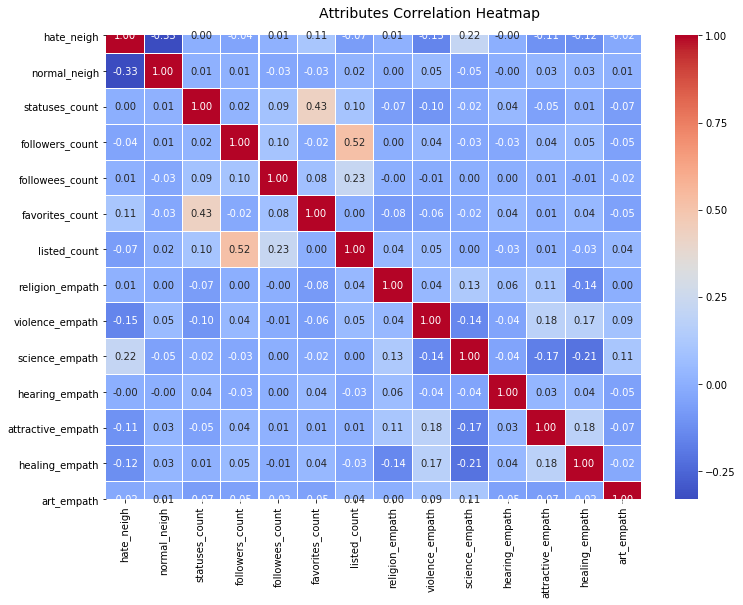

In [0]:
features = ['hate_neigh', 'normal_neigh', 'statuses_count', 'followers_count', 'followees_count', 'favorites_count',
          'listed_count', 'religion_empath','violence_empath', 'science_empath', 'hearing_empath', 'attractive_empath',
          'healing_empath', 'art_empath']
df_labeled_visullize = df_labeled[features]
f, ax = plt.subplots(figsize=(12, 8))
corr = df_labeled_visullize.corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f', linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('Attributes Correlation Heatmap', fontsize=14)

The following graph shows two things. First, if you look at the diagonal line, this shows that most features are normally distributed with some outliers. Second, all other graphs besides the diagnoal show that there is no obvious patterns and correlations between most of two features. Datapoints are scatter quite evenly around in the left bottom cornor. This also shows in the above correlation graph where most pairs of features has almost 0 correlation. 

/opt/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


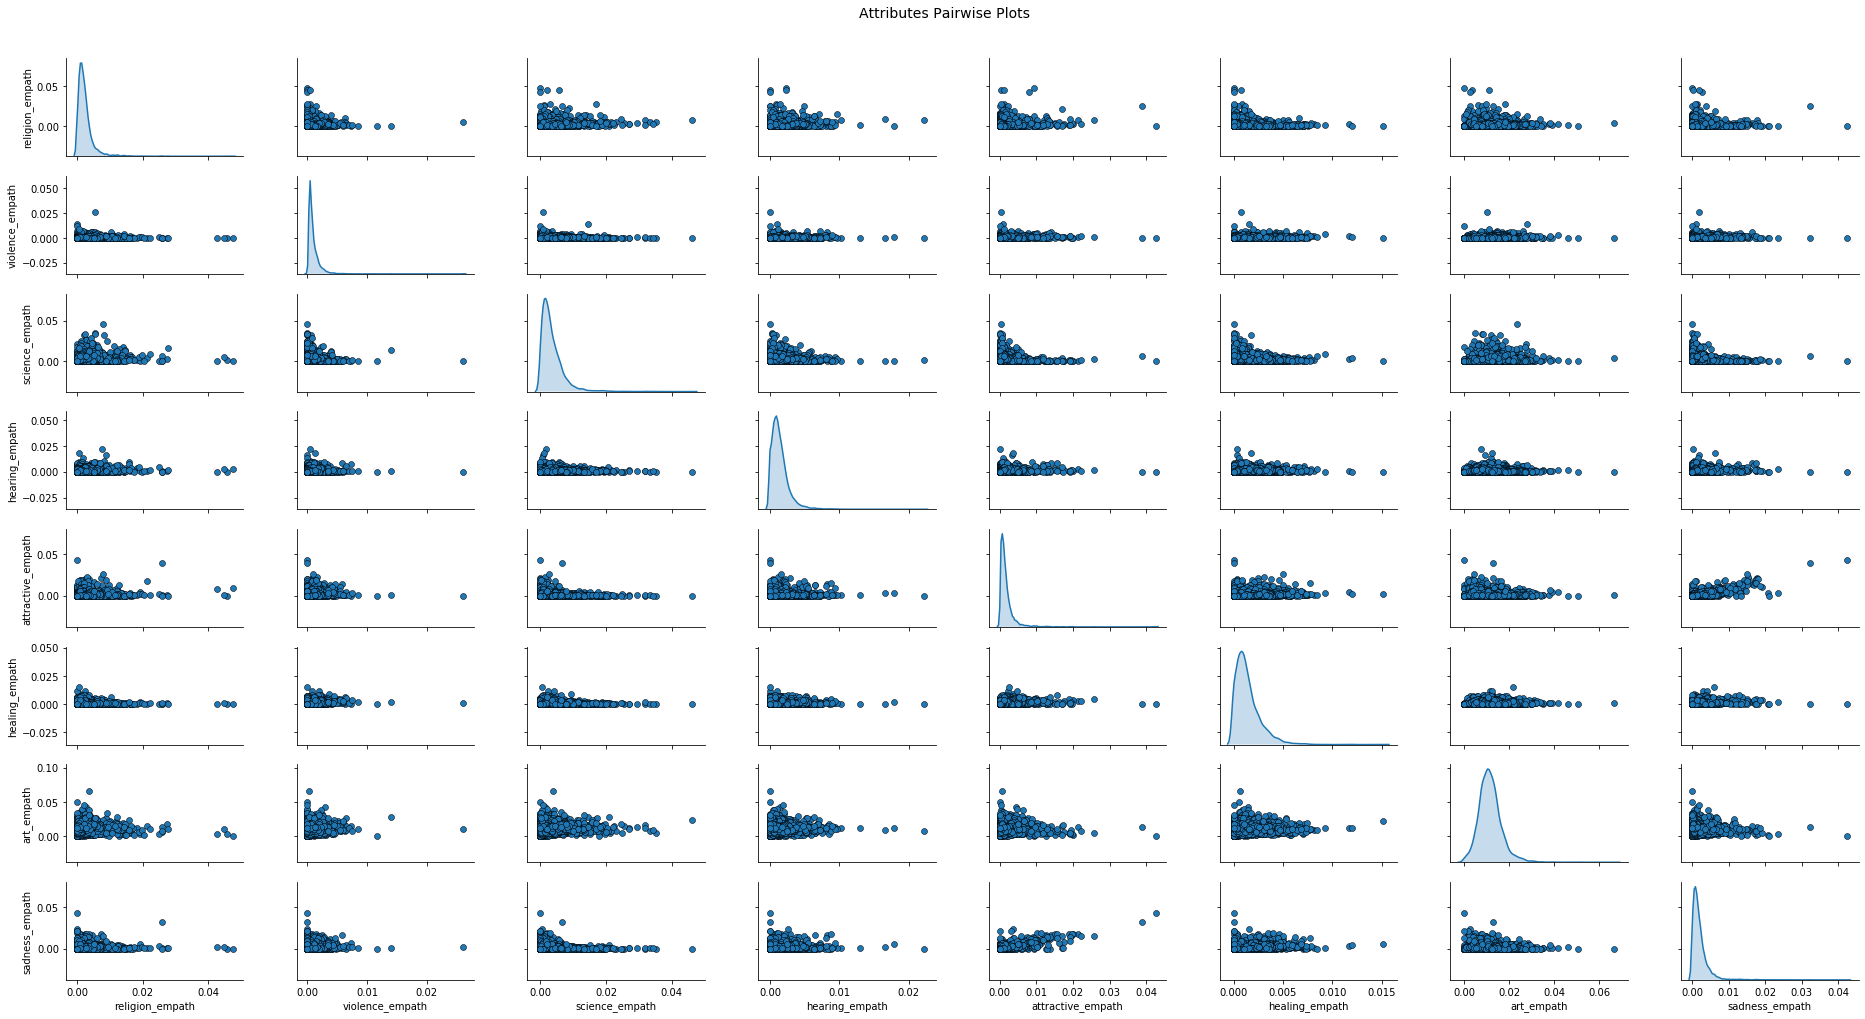

In [0]:
features = ['religion_empath','violence_empath', 'science_empath', 'hearing_empath',
            'attractive_empath','healing_empath', 'art_empath', 'sadness_empath']
pp = sns.pairplot(df_labeled[features], size=1.8, aspect=1.8,
                  plot_kws=dict(edgecolor="k", linewidth=0.5),
                  diag_kind="kde", diag_kws=dict(shade=True))

fig = pp.fig 
fig.subplots_adjust(top=0.93, wspace=0.3)
t = fig.suptitle('Attributes Pairwise Plots', fontsize=14)

## Bar graph

The following two bar graphs are interesting and leads to our hypothesis. I found that most hateful users have hateful neighbors and most normal users have users neighbors.

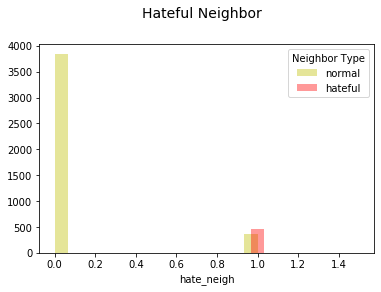

In [0]:
fig = plt.figure(figsize = (6, 4))
title = fig.suptitle("Hateful Neighbor", fontsize=14)
fig.subplots_adjust(top=0.85, wspace=0.3)
ax = fig.add_subplot(1,1, 1)
g = sns.FacetGrid(df_labeled, hue='hate', palette={"hateful": "r", "normal": "y"})
g.map(sns.distplot, 'hate_neigh', kde=False, bins=15, ax=ax)
ax.legend(title='Neighbor Type')
plt.close(2)

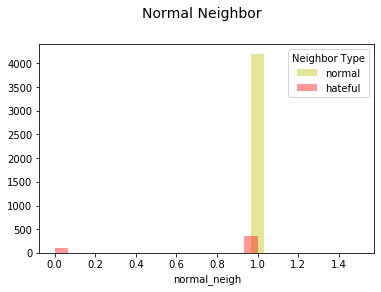

In [0]:
fig = plt.figure(figsize = (6, 4))
title = fig.suptitle("Normal Neighbor", fontsize=14)
fig.subplots_adjust(top=0.85, wspace=0.3)
ax = fig.add_subplot(1,1, 1)
g = sns.FacetGrid(df_labeled, hue='hate', palette={"hateful": "r", "normal": "y"})
g.map(sns.distplot, 'normal_neigh', kde=False, bins=15, ax=ax)
ax.legend(title='Neighbor Type')
plt.close(2)

## Hypothesis
"hate_neigh" is an important features for deciding whethere a user is hateful or not. 

# Model

## Prepare data to feature and label

In [0]:
# create label for the model
df_labeled = df_labeled.replace("hateful", 1)
df_labeled = df_labeled.replace("normal", 0)
df_labeled = df_labeled.rename(columns={"hate":"label"})
y = df_labeled[['label']]

In [0]:
# create features for the model
del df_labeled['label']
x = df_labeled._get_numeric_data()

In [0]:
x.dtypes.head(37)

hate_neigh                 int64
normal_neigh               int64
statuses_count             int64
followers_count            int64
followees_count            int64
favorites_count            int64
listed_count               int64
betweenness              float64
eigenvector              float64
in_degree                float64
out_degree               float64
negotiate_empath         float64
vehicle_empath           float64
science_empath           float64
timidity_empath          float64
gain_empath              float64
swearing_terms_empath    float64
office_empath            float64
tourism_empath           float64
computer_empath          float64
violence_empath          float64
horror_empath            float64
dispute_empath           float64
sadness_empath           float64
internet_empath          float64
college_empath           float64
attractive_empath        float64
plant_empath             float64
technology_empath        float64
reading_empath           float64
deception_

## 1. Logistic regression on raw data
Run logistic regression directly on the dataset.

In [0]:
# Logistic regression on raw data
x_raw = StandardScaler().fit_transform(x)
X_train, X_test, y_train, y_test = train_test_split(x_raw, y, test_size=0.33, random_state=50)
clf1 = LogisticRegression(solver = 'lbfgs')
clf1.fit(X_train, y_train)
y_score1 = clf1.predict_proba(X_test)[:,1]
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_test, y_score1)
confusion_matrix1 = confusion_matrix(y_test, clf1.predict(X_test))
np.argsort(clf1.coef_[0])

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


array([  1, 120, 170, ...,  80, 979,   0])

Here, we list the weights in decending order. The biggest weight is given to "hate_neigh", indicating that whether the user has a hateful neighbor or not is the most important feature. After that, it's "weapon_empath" and "ugliness_empath", being the second and third important features.

roc_auc_score for Logistic Regression:  0.9623538011695908
Accuracy for Logistic Regression:  0.9330299089726918
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      1386
           1       0.68      0.61      0.64       152

    accuracy                           0.93      1538
   macro avg       0.82      0.79      0.80      1538
weighted avg       0.93      0.93      0.93      1538

[[1342   44]
 [  59   93]]


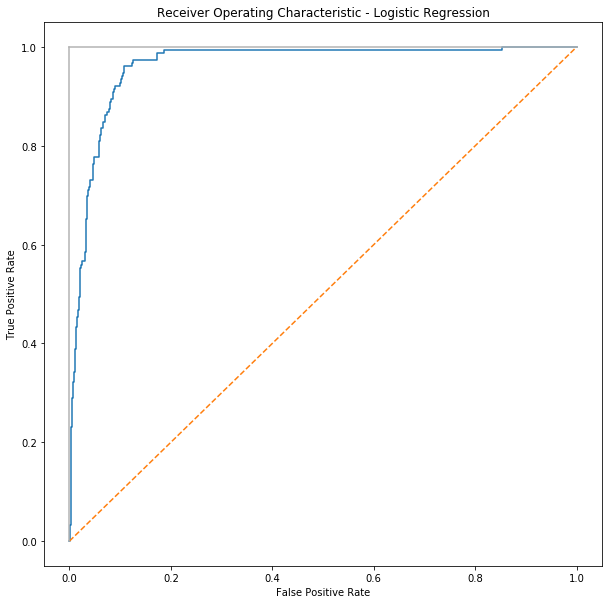

In [0]:
print('roc_auc_score for Logistic Regression: ', roc_auc_score(y_test, y_score1))
print('Accuracy for Logistic Regression: ', clf1.score(X_test, y_test))
print(classification_report(y_test,clf1.predict(X_test)))
print(confusion_matrix1)
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Logistic Regression')
plt.plot(false_positive_rate1, true_positive_rate1)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## 2. Logistic regression with naive PCA
Naively run PCA on the whole data set with 85 principal conponents which together explained 80% of the variance. 

In [0]:
# naive PCA for the feature
x_naive = StandardScaler().fit_transform(x)
pca = PCA(n_components=85)
principalComponents = pca.fit_transform(x_naive)
naivePCA = pd.DataFrame(data = principalComponents)
print(pca.explained_variance_ratio_.sum())
naivePCA

0.8032910510685378


,0,1,2,3,4,5,6,7,8,9,...,75,76,77,78,79,80,81,82,83,84
0,-8.818164,3.920316,-5.820831,2.814710,-1.495260,5.064680,-3.074824,2.689563,2.777561,2.488541,...,-1.973363,-1.633346,-0.044665,1.420754,-0.712278,-0.927561,-0.265898,-1.655048,-0.211241,-0.773930
1,-21.086275,7.575525,6.030197,-3.806779,-4.712142,-8.200879,4.681808,4.215481,1.188158,-0.547137,...,2.204152,-1.193460,1.287163,0.835676,-0.490632,-1.062876,1.334813,0.124436,0.928371,-0.562367
2,-0.517727,-3.596609,3.076497,2.554842,-5.301479,1.646440,-1.955557,-1.460779,7.964477,-2.205932,...,-0.561528,-0.429794,0.484860,-0.474512,-0.109062,-0.914361,-0.371530,0.584157,-0.575942,-1.026137
3,21.406246,1.928309,-0.794780,-8.796819,9.519020,0.517740,-4.785903,4.423476,-1.099735,0.354918,...,-0.220766,-0.067881,1.429547,0.131188,0.056617,-1.325237,-0.241817,-0.840756,-0.437703,0.676259
4,8.057718,3.983101,-7.329639,-2.608503,-1.643623,2.173261,0.210314,0.624018,-0.329932,-2.088900,...,-0.148323,-0.903048,0.365297,1.807345,1.377106,-0.220186,0.423215,-0.962362,0.439806,0.942228
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4654,-6.644969,-0.035626,-4.977753,3.552373,-0.193956,3.350632,-2.130680,1.353154,-1.493883,-1.036339,...,-1.335028,-0.254327,0.461243,0.112793,0.456791,0.116382,0.840886,1.120648,0.050358,-0.895059
4655,1.380350,-0.431870,-7.569531,1.969848,-1.791091,-1.736286,-0.333340,-0.271513,-2.888801,0.711999,...,-0.844304,-0.734847,-0.949653,1.267913,-1.664895,0.365931,0.921383,1.220877,0.082986,-0.253532
4656,2.677974,-4.723763,-0.936330,2.071654,-3.412839,13.580367,-7.331792,5.722821,-2.947053,0.949295,...,-0.099901,0.050879,1.808054,-0.943514,0.490663,1.206866,4.315599,1.183771,-1.928771,1.220231
4657,3.298413,4.618681,-12.616142,-0.494099,-2.341017,5.554384,-2.834462,-1.092629,-2.672946,3.724723,...,-0.404773,-0.054645,-0.194305,0.907749,-0.350052,0.403824,-0.908794,-0.484136,0.378009,-0.102878


In [0]:
# Logistic regression on naive PCA
X_train, X_test, y_train, y_test = train_test_split(naivePCA, y, test_size=0.33, random_state=50)
clf2 = LogisticRegression(solver = 'lbfgs')
clf2.fit(X_train, y_train)
y_score2 = clf2.predict_proba(X_test)[:,1]
false_positive_rate2, true_positive_rate2, threshold2 = roc_curve(y_test, y_score2)
confusion_matrix2 = confusion_matrix(y_test, clf2.predict(X_test))

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


roc_auc_score for naive PCA Logistic Regression:  0.9396407685881369
Accuracy for naive PCA Logistic Regression:  0.9343302990897269
              precision    recall  f1-score   support

           0       0.95      0.98      0.96      1386
           1       0.73      0.53      0.62       152

    accuracy                           0.93      1538
   macro avg       0.84      0.76      0.79      1538
weighted avg       0.93      0.93      0.93      1538

[[1356   30]
 [  71   81]]


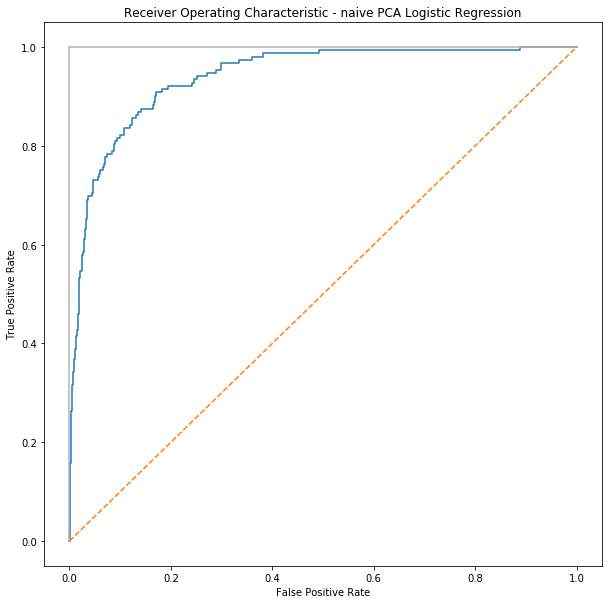

In [0]:
print('roc_auc_score for naive PCA Logistic Regression: ', roc_auc_score(y_test, y_score2))
print('Accuracy for naive PCA Logistic Regression: ', clf2.score(X_test, y_test))
print(classification_report(y_test,clf2.predict(X_test)))
print(confusion_matrix2)
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - naive PCA Logistic Regression')
plt.plot(false_positive_rate2, true_positive_rate2)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## 3. Logistic regression with featured PCA (BEST)
Run featured PCA on selected data set with 85 principal conponents which together explained 80% of the variance. Specifically, I chose all features with (...)empath since they represents similar arrtibutes of the users. Then, combined these 85 PCs to the pre-filtered features in "temp1". By doing this feature engineering, the AUC is able to improve to 0.9778 and the F1 score is 0.71. The BEST model!

In [0]:
# featured PCA 
temp1 = x[['hate_neigh', 'normal_neigh', 'statuses_count', 'followers_count', 'followees_count', 'favorites_count',
          'listed_count', 'betweenness']]
temp1 = temp1.reset_index(drop=True)
temp2 = x.drop(['hate_neigh', 'normal_neigh', 'statuses_count', 'followers_count', 'followees_count', 'favorites_count',
          'listed_count', 'betweenness', 'eigenvector', 'in_degree', 'out_degree'], axis = 1)
x_feature = StandardScaler().fit_transform(temp2)
pca = PCA(n_components=85)
principalComponents = pca.fit_transform(x_feature)
featurePCA = pd.DataFrame(data = principalComponents)
featurePCA = pd.concat([featurePCA, temp1], axis = 1)
print(pca.explained_variance_ratio_.sum())
featurePCA

0.8086304022056549


,0,1,2,3,4,5,6,7,8,9,...,83,84,hate_neigh,normal_neigh,statuses_count,followers_count,followees_count,favorites_count,listed_count,betweenness
0,-8.770444,3.761964,-5.789004,2.810779,-1.460552,4.964200,-3.042452,2.688325,2.755654,2.468898,...,-0.716555,0.672678,1,1,101767,3504,3673,81635,53,100467.895084
1,-21.090559,7.705440,5.829119,-3.785577,-4.709625,-8.159522,4.770763,4.195303,1.109045,-0.355890,...,-1.495170,-0.282101,0,1,111948,1586,997,80,7,960.147859
2,-0.545531,-3.518967,3.091879,2.554091,-5.307667,1.637417,-1.940605,-1.476541,7.961531,-1.659078,...,-1.227221,1.571178,0,1,28222,27545,282,916,499,60445.401832
3,21.403814,1.907529,-0.838804,-8.791372,9.518368,0.505290,-4.808815,4.412385,-1.054308,0.489053,...,-0.132800,-0.796287,0,1,3101,2173,923,1193,11,21158.812380
4,8.075211,3.861994,-7.426880,-2.594026,-1.660921,2.195653,0.176218,0.610253,-0.356064,-1.843339,...,1.058381,-0.373064,0,1,49169,2321,206,24755,37,4926.513875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4654,-6.636651,-0.102532,-4.990287,3.555736,-0.209148,3.371428,-2.193469,1.351761,-1.456456,-0.969162,...,-0.232010,-0.048562,0,1,27894,3967,2077,15159,137,137656.174845
4655,1.387588,-0.543111,-7.582687,1.975068,-1.811889,-1.696603,-0.367363,-0.270664,-2.865032,0.469846,...,-0.296327,0.819346,0,1,5607,676,444,2664,24,16388.187011
4656,2.646022,-4.704106,-0.908593,2.063699,-3.418913,13.573179,-7.466955,5.711658,-2.902687,1.478197,...,0.833596,-1.233995,0,1,34,7534,527,1393,298,9278.713536
4657,3.295424,4.399075,-12.598797,-0.515953,-2.321667,5.482672,-2.816359,-1.075324,-2.684086,3.438990,...,0.025930,-0.156534,1,1,14608,49583,615,5373,927,153084.227764


In [0]:
# Logistic regression on featured PCA
featurePCA = StandardScaler().fit_transform(featurePCA)
X_train, X_test, y_train, y_test = train_test_split(featurePCA, y, test_size=0.33, random_state=50)
clf3 = LogisticRegression(solver = 'lbfgs')
clf3.fit(X_train, y_train)
y_score3 = clf3.predict_proba(X_test)[:,1]
false_positive_rate3, true_positive_rate3, threshold3 = roc_curve(y_test, y_score3)
confusion_matrix3 = confusion_matrix(y_test, clf3.predict(X_test))

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


roc_auc_score for featured PCA Logistic Regression:  0.9777663856611225
Accuracy for featured PCA Logistic Regression:  0.9453836150845254
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1386
           1       0.74      0.68      0.71       152

    accuracy                           0.95      1538
   macro avg       0.85      0.83      0.84      1538
weighted avg       0.94      0.95      0.94      1538

[[1350   36]
 [  48  104]]


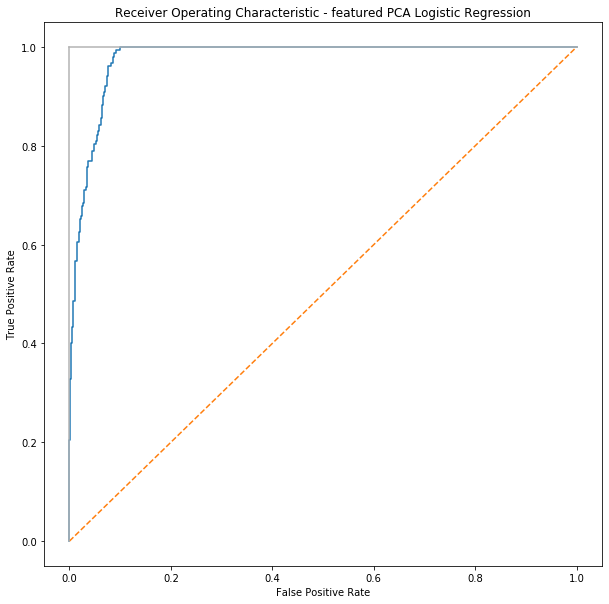

In [0]:
print('roc_auc_score for featured PCA Logistic Regression: ', roc_auc_score(y_test, y_score3))
print('Accuracy for featured PCA Logistic Regression: ', clf3.score(X_test, y_test))
print(classification_report(y_test,clf3.predict(X_test)))
print(confusion_matrix3)
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - featured PCA Logistic Regression')
plt.plot(false_positive_rate3, true_positive_rate3)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [0]:
print(confusion_matrix1)
print(confusion_matrix2)
print(confusion_matrix3)

[[1342   44]
 [  59   93]]
[[1356   30]
 [  71   81]]
[[1350   36]
 [  48  104]]


Comparing their confusion matrixs, we find the featured PCA performed significantly better than the naive PCA and logistic regression.

## 4. Decision Tree 

First, do a cross-validation to select the best hyperparameter (max_depth) for the decision tree. According to the following graph, we found the best hyperparameter is max_depth = 4.

Text(0, 0.5, 'F1, AUC')

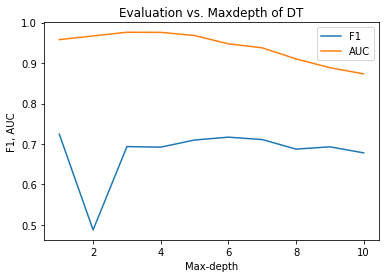

In [0]:
# Decision Tree Hyperparameter tuning
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=50)
depth = np.linspace(1,10,10)
score = []
auc = []
for i in depth:
    temp_model = DecisionTreeClassifier(max_depth = i)
    scores = cross_val_score(estimator=temp_model, X=X_train, y=y_train, cv=5, scoring='f1', n_jobs=4)
    aucs = cross_val_score(estimator=temp_model, X=X_train, y=y_train, cv=5, scoring='roc_auc', n_jobs=4)
    score.append(scores.mean())
    auc.append(aucs.mean())

plt.plot(depth, score, label="F1")
plt.plot(depth, auc, label="AUC")
plt.legend()
plt.title("Evaluation vs. Maxdepth of DT")
plt.xlabel("Max-depth")
plt.ylabel("F1, AUC")

Here, we use the hyperparamter we found previously to train a decision tree model. This is the second best model we found with AUC being 0.9754 and F1 score being 0.67. However, decision tree has better explainability for the model. We can see the most important feature (the first question that the decision tree ask) is also "hate_neigh", with "normal_neigh" and "hearing_empath" following. 

roc_auc_score for Decision Tree:  0.97539777473988
Accuracy for Decision Tree:  0.9427828348504551
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1386
           1       0.77      0.60      0.67       152

    accuracy                           0.94      1538
   macro avg       0.86      0.79      0.82      1538
weighted avg       0.94      0.94      0.94      1538

[[1359   27]
 [  61   91]]


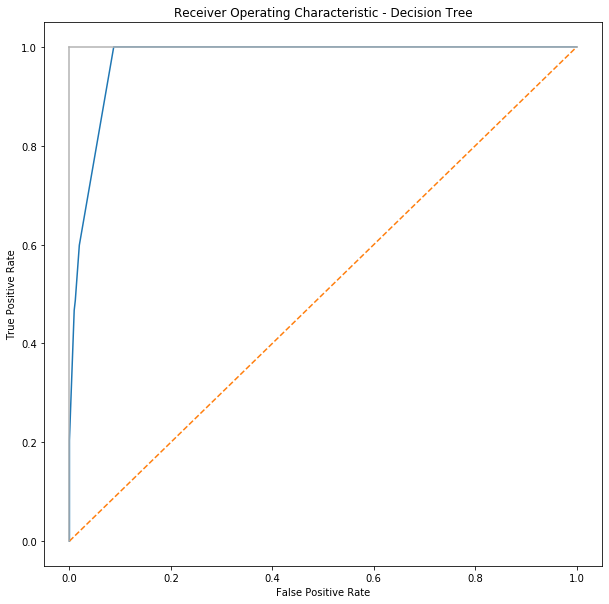

In [0]:
# Decision Tree
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=50)
clf4 = DecisionTreeClassifier(max_depth = 4)
clf4.fit(X_train, y_train)
y_score4 = clf4.predict_proba(X_test)[:,1]
false_positive_rate4, true_positive_rate4, threshold4 = roc_curve(y_test, y_score4)
confusion_matrix4 = confusion_matrix(y_test, clf4.predict(X_test))
print('roc_auc_score for Decision Tree: ', roc_auc_score(y_test, y_score4))
print('Accuracy for Decision Tree: ', clf4.score(X_test, y_test))
print(classification_report(y_test,clf4.predict(X_test)))
print(confusion_matrix4)
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Decision Tree')
plt.plot(false_positive_rate4, true_positive_rate4)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

[Text(209.25, 733.86, 'X[0] <= 0.5\ngini = 0.178\nsamples = 3121\nvalue = [2813, 308]'),
 Text(104.625, 570.78, 'gini = 0.0\nsamples = 2575\nvalue = [2575, 0]'),
 Text(313.875, 570.78, 'X[1] <= 0.5\ngini = 0.492\nsamples = 546\nvalue = [238, 308]'),
 Text(209.25, 407.70000000000005, 'gini = 0.0\nsamples = 76\nvalue = [0, 76]'),
 Text(418.5, 407.70000000000005, 'X[37] <= 0.004\ngini = 0.5\nsamples = 470\nvalue = [238, 232]'),
 Text(209.25, 244.62, 'X[489] <= 0.002\ngini = 0.452\nsamples = 302\nvalue = [198, 104]'),
 Text(104.625, 81.54000000000008, 'gini = 0.431\nsamples = 286\nvalue = [196, 90]'),
 Text(313.875, 81.54000000000008, 'gini = 0.219\nsamples = 16\nvalue = [2, 14]'),
 Text(627.75, 244.62, 'X[552] <= -0.202\ngini = 0.363\nsamples = 168\nvalue = [40, 128]'),
 Text(523.125, 81.54000000000008, 'gini = 0.499\nsamples = 57\nvalue = [27, 30]'),
 Text(732.375, 81.54000000000008, 'gini = 0.207\nsamples = 111\nvalue = [13, 98]')]

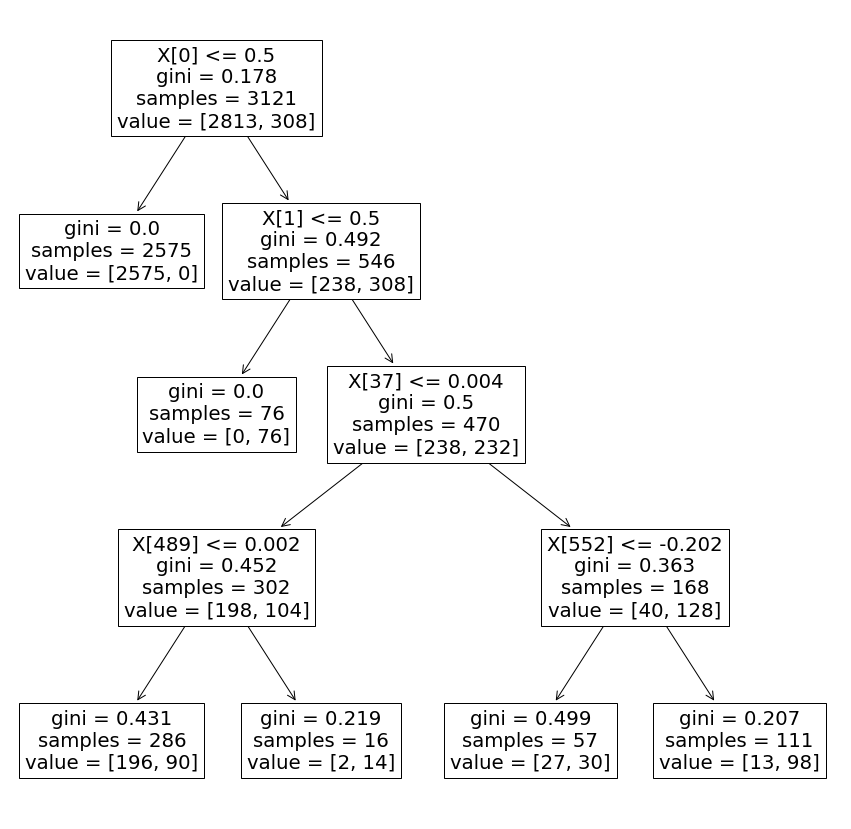

In [0]:
fig, ax = plt.subplots(1, figsize=(15,15))
tree.plot_tree(clf4, ax = ax)

## 5. XG-boost

Last, we use the XG-boost algorithm. The XG-boost gives a AUC being 0.9754, the same as decision tree, and F1 score being 0.65. An important insights that this XG-boost algorithm gives us is the feature important, which is our hypothesis that need to be tested. We can see in the last graph, "normal_neigh" is the most important feature. Also, "hate_neigh" has importance 3. An interesting thing is that "furniture_empath" has an importance socre 4 which never shows up in previous models. 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


roc_auc_score for Decision Tree:  0.97539777473988
Accuracy for Decision Tree:  0.9427828348504551
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1386
           1       0.82      0.54      0.65       152

    accuracy                           0.94      1538
   macro avg       0.89      0.76      0.81      1538
weighted avg       0.94      0.94      0.94      1538

[[1368   18]
 [  70   82]]


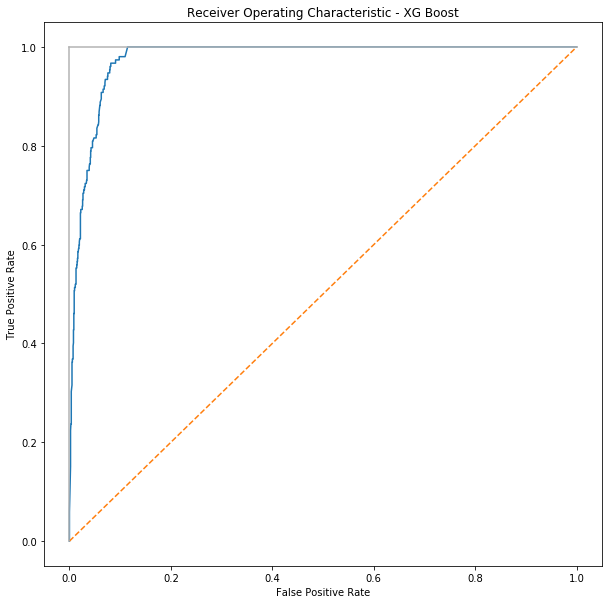

In [0]:
# XG-boost
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=50)
xg_clas = xgb.XGBClassifier(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 3, alpha = 10, n_estimators = 10)
xg_clas.fit(X_train,y_train)
preds = xg_clas.predict(X_test)
y_score5 = xg_clas.predict_proba(X_test)[:,1]
false_positive_rate5, true_positive_rate5, threshold5 = roc_curve(y_test, y_score5)
confusion_matrix5 = confusion_matrix(y_test, xg_clas.predict(X_test))
print('roc_auc_score for Decision Tree: ', roc_auc_score(y_test, y_score4))
print('Accuracy for Decision Tree: ', xg_clas.score(X_test, y_test))
print(classification_report(y_test,xg_clas.predict(X_test)))
print(confusion_matrix5)
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - XG Boost')
plt.plot(false_positive_rate5, true_positive_rate5)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

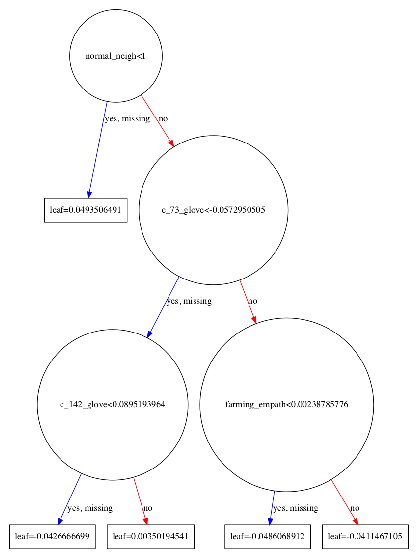

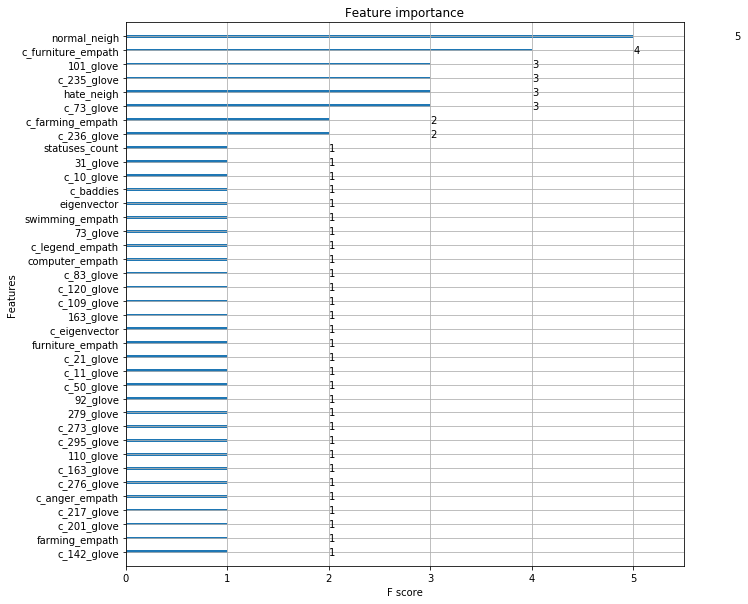

In [0]:
xgb.plot_tree(xg_clas)
plt.rcParams['figure.figsize'] = [10, 10]
plt.show()

xgb.plot_importance(xg_clas)
plt.rcParams['figure.figsize'] = [10, 10]
plt.show()

# Conclusion

In this study, we examine the Twitter user dataset aiming to identify hateful users in the unlabeled data. Models are trained in a supervised setting with the 5k labeled data. The best model is the featured PCA with AUC being 0.9778 and F1 score being 0.71. I also testify the hypothesis that having a hateful neighbor is an important feature in predicting hateful Twitter users. Along the analysis, I also find many other interesting features like hearing_empath and furniture_empath. This study hope to use trained model to predict hateful users on Twitter and prevent the spread of inappropriate message at the earliest stage, creating a harmonious environment. 

# Future study

In the future, graph algorithm could be applied to identify more interesting features. Also, a graph visilization with node being user and edge being theri connection can be used to better understand the structure of the network. Also, more hyperparameter tuning could be done to trim to model to better. 